# Plotting Hubble Residuals
 
Creates Hubble diagram and plots residuals

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from scipy.stats import chisquare
from scipy.optimize import minimize
#imports

In [2]:
sdss_combined = pd.read_csv('../results/sdss_combined.csv')
#read in table

#rerun minimizer for hubble residual - avg hubble residual
calculate avg distance modulus
use value to calc difference betwen dist mod and avg
fit residuals 
recover cos model from the fit

## Finding a Best Fit Cosmology

39.351735330836455


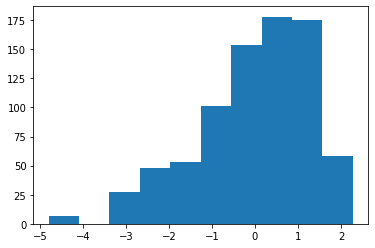

In [3]:
#assume Om0 value
Om0_assumed = 0.315
#define variables
redshift = sdss_combined['zCMB'].to_numpy()
dist_mod = sdss_combined['muSALT2zspec'].to_numpy()
dist_mod_err = sdss_combined['muerrSALT2zspec'].to_numpy()
stretch = sdss_combined['x1SALT2zspec'].to_numpy()
color = sdss_combined['cSALT2zspec'].to_numpy()
#take average of distance moduli and subtract from dist mod data. Use std as error
dist_mod_avg = np.mean(dist_mod)
difference = dist_mod - dist_mod_avg
diff_err = np.std(difference)
#plots a histogram of the differences from the average
plt.hist(difference)
print(dist_mod_avg)

In [17]:
def chisq_dist_mod(params):
    #defines chisq function 
    H0, alpha, beta = params
    #creates cosmology model with no curvature, and obtains modeled distance moduli 
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0_assumed)
    model_dist_mod = cosmo.distmod(redshift).value
    
    #calculates chisq using the difference and the modeled distance modulus 
    return np.sum((difference - model_dist_mod) ** 2 / dist_mod_err  ** 2)

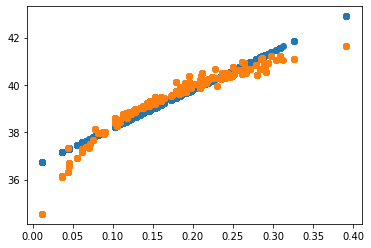

In [18]:
params = np.polyfit(redshift, difference, 1)
fit_func = np.poly1d(params)
red_fit = fit_func(redshift)
dist_mod_fit = red_fit + dist_mod_avg

plt.scatter(redshift, dist_mod_fit)
plt.scatter(redshift, dist_mod)

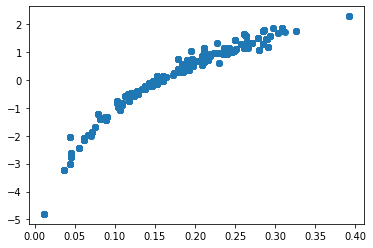

In [19]:
plt.scatter(redshift, difference)

In [20]:
fit_results = minimize(chisq_dist_mod, [10, 0, 0])
fit_results

      fun: 772404.6541962286
 hess_inv: array([[1.51958846e+09, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 190
      nit: 34
     njev: 38
   status: 0
  success: True
        x: array([3.01786224e+08, 0.00000000e+00, 0.00000000e+00])

In [21]:
our_cosmo = FlatLambdaCDM(H0=fit_results.x[0], Om0=Om0_assumed)
our_cosmo

FlatLambdaCDM(H0=3.02e+08 km / (Mpc s), Om0=0.315, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)

## Plot Fit Results

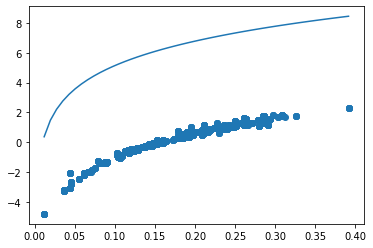

In [28]:
xlim = np.min(redshift), np.max(redshift)
z_plot = np.linspace(*xlim)
plt.plot(z_plot, our_cosmo.distmod(z_plot) )
plt.scatter(redshift, difference)

In [22]:
def plot_hubble_diagram(z, mu, mu_err, fitted_cosmo, avg_dist_mod, figsize=(4, 6)):
    mu_calibrated = mu 
    xlim = np.min(z), np.max(z)
    z_plot = np.linspace(*xlim)
    fitted_dist_mod = our_cosmo.distmod(z_plot).value + avg_dist_mod 
    fitted_dist_mod_z = our_cosmo.distmod(z).value + avg_dist_mod 
    
    fig, (top_ax, bottom_ax) = plt.subplots(2, 1, sharex='col', figsize=figsize, gridspec_kw={'height_ratios': (2, 1)})
    plt.subplots_adjust(hspace=0)
    
    cosmology_style = dict(color='blue', alpha=0.5, label='$h=0.7,\ \Omega_M=0.3,\ \Omega_\Lambda=0.7$')
    mu_style = dict(fmt='none', color='red', alpha=0.5)
    
    top_ax.plot(z_plot, fitted_dist_mod, **cosmology_style)
    top_ax.errorbar(redshift, dist_mod, yerr=dist_mod_err, **mu_style)
    top_ax.set_ylabel('Distance Modulus (mag)')
    
    bottom_ax.axhline(0, **cosmology_style)
    bottom_ax.errorbar(z, mu_calibrated - fitted_dist_mod_z, yerr=dist_mod_err, **mu_style)
    bottom_ax.set_xlim(*xlim)
    bottom_ax.set_xlabel('Redshift')
    bottom_ax.set_ylabel('Residuals')
    

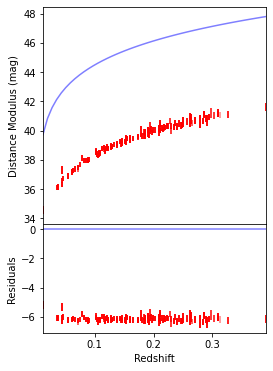

In [23]:
plot_hubble_diagram(redshift, dist_mod, dist_mod_err, our_cosmo, dist_mod_avg)


In [ ]:
resid = dist_mod - our_cosmo.distmod(redshift).value
sdss_combined['residuals'] = resid.tolist()
sdss_combined.to_csv(r'/Users/emilysf098/Desktop/Research/SN-Spectral-Evolution/results/residual_df.csv')

TEST

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(stretch, sdss_combined['residuals'], marker = '.')
w = 1/dist_mod_err
ms, bs = np.polyfit(stretch, sdss_combined['residuals'], 1, w = w)
plt.plot(stretch, ms*stretch + bs, color = 'orange')
plt.errorbar(stretch,sdss_combined['residuals'] , yerr=dist_mod_err, alpha = 0.1, linestyle = '')
plt.title('Stretch vs. Residual')
plt.xlabel('stretch')
plt.ylabel('residual')
print(f'slope = {ms}, y-intercept =  {bs}')

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(color, sdss_combined['residuals'], marker = '.')
mc, bc = np.polyfit(color, sdss_combined['residuals'], 1, w=w)
plt.plot(color, mc*color + bc, color = 'orange')
plt.errorbar(color,sdss_combined['residuals'] , yerr=dist_mod_err, alpha = 0.1, linestyle = '')
plt.title('Color vs. Residual')
plt.xlabel('color')
plt.ylabel('residual')
print(f'slope = {mc}, y-intercept =  {bc}')

In [ ]:
#removing outliers
no_out_resid = sdss_combined[(sdss_combined['residuals']<3) & (sdss_combined['x1SALT2zspec'] < 0.6)]
no_out_resid2 = sdss_combined[(sdss_combined['residuals']<3) & (sdss_combined['cSALT2zspec'] < 0.6)]

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(no_out_resid['x1SALT2zspec'], no_out_resid['residuals'], marker = '.')
ms, bs = np.polyfit(no_out_resid['x1SALT2zspec'], no_out_resid['residuals'], 1)
plt.plot(no_out_resid['x1SALT2zspec'], ms*no_out_resid['x1SALT2zspec'] + bs, color = 'orange')
plt.title('Stretch vs. Residual')
plt.xlabel('stretch')
plt.ylabel('residual')
print(f'slope = {ms}, y-intercept =  {bs}')

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(no_out_resid2['cSALT2zspec'], no_out_resid2['residuals'], marker = '.')
ms, bs = np.polyfit(no_out_resid2['cSALT2zspec'], no_out_resid2['residuals'], 1)
plt.plot(no_out_resid2['cSALT2zspec'], ms*no_out_resid2['cSALT2zspec'] + bs, color = 'orange')
plt.title('color vs. Residual')
plt.xlabel('color')
plt.ylabel('residual')
print(f'slope = {ms}, y-intercept =  {bs}')